In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor, IsotonicRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import expm1
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

import scipy.stats as stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson

In [5]:
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [6]:
df_train = spark.read.parquet('/Users/jennymai/Desktop/data_sci/mast_project1/data/development')

In [7]:
rmse_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='rmse')
mae_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='mae')
r2_evaluator = RegressionEvaluator(labelCol='fare_amount', predictionCol='prediction', metricName='r2')

In [8]:
df_train.count()

4393759

In [9]:
df_train = df_train.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')

In [10]:
# df_train.columns

In [11]:
df_train_sample = df_train#.sample(fraction=0.1, seed=1003)

relevant_columns = ['VendorID',
                    'trip_distance',
                    'RatecodeID',
                    'PULocationID',
                    'DOLocationID',
                    'extra',
                    'mta_tax',
                    'tolls_amount',
                    'improvement_surcharge',
                    'congestion_surcharge',
                    'airport_fee',
                    'trip_duration_mins',
                    'pickup_hour',
                    'pickup_dayofweek',
                    'dropoff_hour',
                    'dropoff_dayofweek',
                    'days_since_2022_11_01',
                    'distance_time_interaction',
                    'is_airport_trip',
                    'is_tourist_trip',
                    'pickup_at_airport',
                    'dropoff_at_airport',
                    'pickup_at_tourist_attraction',
                    'dropoff_at_tourist_attraction',
                    'is_holiday_season',
                    'is_event_day',
                    'avg_temp',
                    ]


train_data = df_train_sample.filter(col('days_since_2022_11_01').between(0, 143))
test_data = df_train_sample.filter(col('days_since_2022_11_01').between(144, 180))

In [12]:
fare_assembler = VectorAssembler(inputCols=relevant_columns, outputCol='unscaled_features')
fare_train_assembled = fare_assembler.transform(train_data)
fare_test_assembled = fare_assembler.transform(test_data)

In [13]:
fare_scaler = StandardScaler(inputCol='unscaled_features', outputCol='scaled_features')
fare_scaler_model = fare_scaler.fit(fare_train_assembled)
fare_train_scaled = fare_scaler_model.transform(fare_train_assembled).select('scaled_features', 'fare_amount')
fare_test_scaled = fare_scaler_model.transform(fare_test_assembled).select('scaled_features', 'fare_amount')

24/08/21 13:54:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
fare_train_scaled.count()

4392234

In [15]:
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='fare_amount', seed=1003, numTrees=40)
rf_model = rf.fit(fare_train_scaled)

24/08/21 13:57:22 WARN MemoryStore: Not enough space to cache rdd_40_2 in memory! (computed 66.3 MiB so far)
24/08/21 13:57:22 WARN BlockManager: Persisting block rdd_40_2 to disk instead.
24/08/21 13:57:24 WARN MemoryStore: Not enough space to cache rdd_40_0 in memory! (computed 103.2 MiB so far)
24/08/21 13:57:24 WARN BlockManager: Persisting block rdd_40_0 to disk instead.
24/08/21 13:57:24 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 103.2 MiB so far)
24/08/21 13:57:24 WARN BlockManager: Persisting block rdd_40_1 to disk instead.
24/08/21 13:57:41 WARN MemoryStore: Not enough space to cache rdd_40_2 in memory! (computed 44.0 MiB so far)
24/08/21 13:57:41 WARN MemoryStore: Not enough space to cache rdd_40_1 in memory! (computed 66.3 MiB so far)
24/08/21 13:57:53 WARN MemoryStore: Not enough space to cache rdd_40_0 in memory! (computed 103.2 MiB so far)
24/08/21 13:57:53 WARN MemoryStore: Not enough space to cache rdd_40_4 in memory! (computed 12.9 MiB so

In [16]:
rf_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/rf_model")

In [17]:
rf_predictions = rf_model.transform(fare_test_scaled)

rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_mae = mae_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
print(f"Random Forest Regressor on test_data - RMSE: {rf_rmse}, MAE: {rf_mae}, R2: {rf_r2}")

Random Forest Regressor on test_data - RMSE: 7.972276760962537, MAE: 4.922002379691761, R2: 0.7796763408813228


In [18]:
rf_residuals = rf_predictions.select('fare_amount', 'prediction', (rf_predictions['fare_amount'] - rf_predictions['prediction']).alias('residuals'))

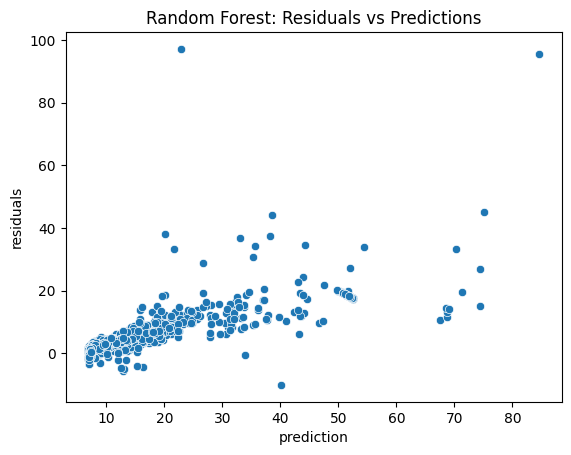

In [34]:
rf_residuals_pandas = rf_residuals.toPandas()
sns.scatterplot(x=rf_residuals_pandas['prediction'], y=rf_residuals_pandas['residuals'])
plt.title("Random Forest: Residuals vs Predictions")
plt.show()

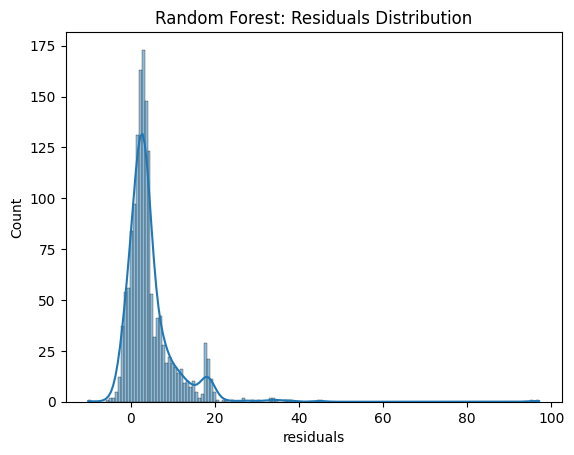

In [20]:
sns.histplot(rf_residuals_pandas['residuals'], kde=True)
plt.title("Random Forest: Residuals Distribution")
plt.show()

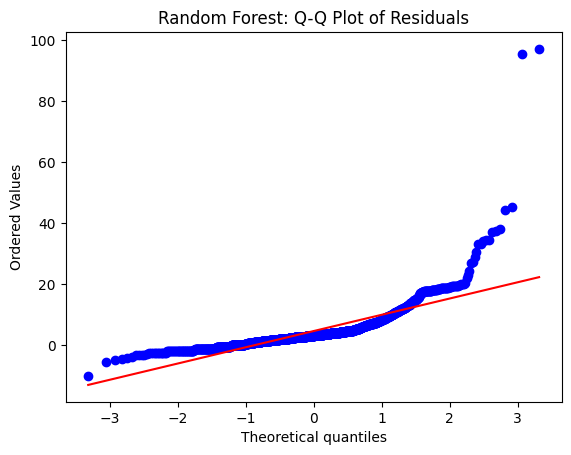

In [21]:
stats.probplot(rf_residuals_pandas['residuals'], dist="norm", plot=plt)
plt.title("Random Forest: Q-Q Plot of Residuals")
plt.show()

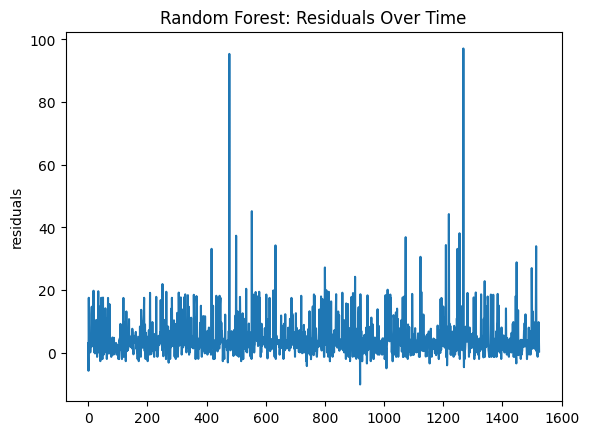

In [22]:
sns.lineplot(x=range(len(rf_residuals_pandas['residuals'])), y=rf_residuals_pandas['residuals'])
plt.title("Random Forest: Residuals Over Time")
plt.show()

In [23]:
feature_importances = rf_model.featureImportances

feature_names = relevant_columns

feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}

print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"Feature: {feature}, Importance: {importance}")

Feature Importances:
Feature: VendorID, Importance: 1.7573770192729143e-05
Feature: trip_distance, Importance: 0.44755311104773493
Feature: RatecodeID, Importance: 0.08741561217392625
Feature: PULocationID, Importance: 0.0018604402624410737
Feature: DOLocationID, Importance: 0.005892613580990342
Feature: extra, Importance: 0.0005375078345954138
Feature: mta_tax, Importance: 0.012853891405482262
Feature: tolls_amount, Importance: 0.04464761641132909
Feature: improvement_surcharge, Importance: 4.244186321511078e-07
Feature: congestion_surcharge, Importance: 0.0008384860757707013
Feature: airport_fee, Importance: 0.009894831484485334
Feature: trip_duration_mins, Importance: 0.1465988230237214
Feature: pickup_hour, Importance: 0.0020767096074566474
Feature: pickup_dayofweek, Importance: 9.827375588471118e-08
Feature: dropoff_hour, Importance: 0.001304272246762896
Feature: dropoff_dayofweek, Importance: 6.974756563056963e-07
Feature: days_since_2022_11_01, Importance: 3.666386208313546e-06


In [24]:
gdb = GBTRegressor(featuresCol='scaled_features', labelCol='fare_amount', seed=1003, maxDepth=5, maxIter=60, stepSize=0.15)
gdb_model = gdb.fit(fare_train_scaled)

24/08/21 14:01:24 WARN MemoryStore: Not enough space to cache rdd_129_1 in memory! (computed 70.0 MiB so far)
24/08/21 14:01:24 WARN BlockManager: Persisting block rdd_129_1 to disk instead.
24/08/21 14:01:24 WARN MemoryStore: Not enough space to cache rdd_129_2 in memory! (computed 70.0 MiB so far)
24/08/21 14:01:24 WARN BlockManager: Persisting block rdd_129_2 to disk instead.
24/08/21 14:01:29 WARN MemoryStore: Not enough space to cache rdd_129_1 in memory! (computed 46.0 MiB so far)
24/08/21 14:01:30 WARN MemoryStore: Not enough space to cache rdd_129_2 in memory! (computed 46.0 MiB so far)
24/08/21 14:01:30 WARN MemoryStore: Not enough space to cache rdd_129_4 in memory! (computed 19.5 MiB so far)
24/08/21 14:01:30 WARN BlockManager: Persisting block rdd_129_4 to disk instead.
24/08/21 14:01:31 WARN MemoryStore: Not enough space to cache rdd_129_2 in memory! (computed 13.0 MiB so far)
24/08/21 14:01:31 WARN MemoryStore: Not enough space to cache rdd_129_1 in memory! (computed 13.0

In [25]:
gdb_model.save("/Users/jennymai/Desktop/data_sci/mast_project1/models/gdb_model")

In [26]:
gdb_predictions = gdb_model.transform(fare_test_scaled)

gdb_rmse = rmse_evaluator.evaluate(gdb_predictions)
gdb_mae = mae_evaluator.evaluate(gdb_predictions)
gdb_r2 = r2_evaluator.evaluate(gdb_predictions)

print(f"Gradient Boosting on test_data - RMSE: {gdb_rmse}, MAE: {gdb_mae}, R2: {gdb_r2}")

24/08/21 14:58:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Gradient Boosting on test_data - RMSE: 3.836624069329998, MAE: 1.9595899589323926, R2: 0.9489736039260036


In [27]:
gdb_residuals = gdb_predictions.select('fare_amount', 'prediction', (gdb_predictions['fare_amount'] - gdb_predictions['prediction']).alias('residuals'))

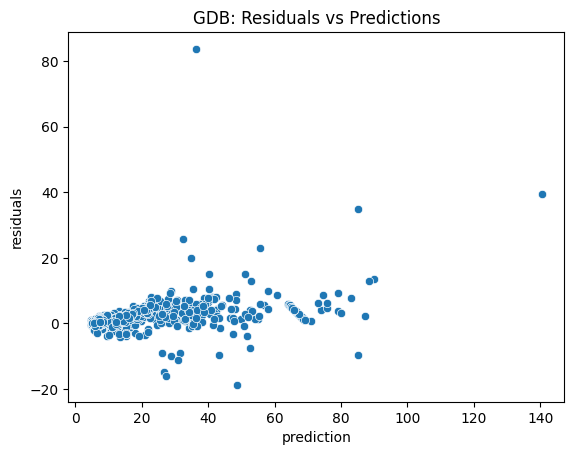

In [28]:
gdb_residuals_pandas = gdb_residuals.toPandas()
sns.scatterplot(x=gdb_residuals_pandas['prediction'], y=gdb_residuals_pandas['residuals'])
plt.title("GDB: Residuals vs Predictions")
plt.show()

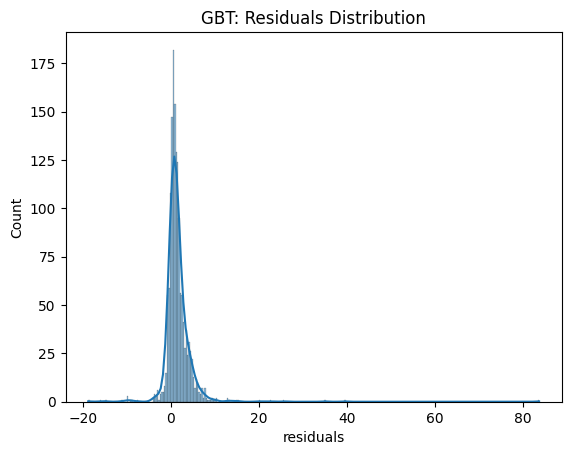

In [29]:
sns.histplot(gdb_residuals_pandas['residuals'], kde=True)
plt.title("GBT: Residuals Distribution")
plt.show()

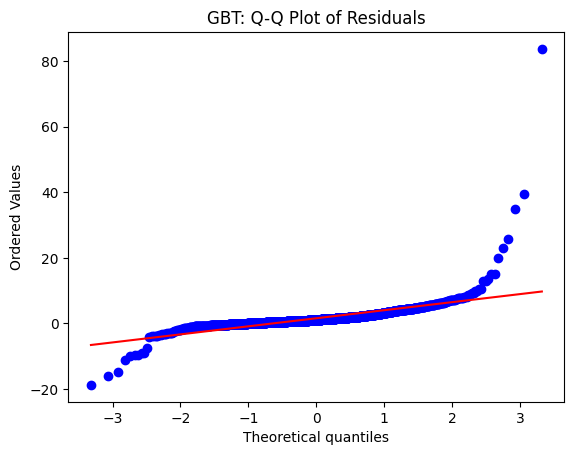

In [30]:
stats.probplot(gdb_residuals_pandas['residuals'], dist="norm", plot=plt)
plt.title("GBT: Q-Q Plot of Residuals")
plt.show()

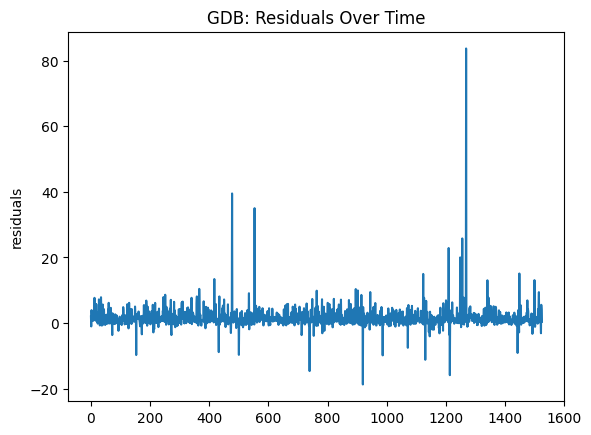

In [31]:
sns.lineplot(x=range(len(gdb_residuals_pandas['residuals'])), y=gdb_residuals_pandas['residuals'])
plt.title("GDB: Residuals Over Time")
plt.show()